# Raster

本章主要记录关于raster processing operations的内容，使用的工具主要是 rasterio module。

## Automatize data download

为了后面的操作，这里首先需要下载一些数据来用。这里展示的是python程序来完成数据的自动下载。

示例数据来自Landsat8 image，因为 教材是芬兰教材，所以针对的区域是Heasinki area；还有DEM数据。使用下面的程序下载数据：

In [2]:
import os
import urllib

def get_filename(url):
    """
    Parses filename from given url
    """
    if url.find('/'):
        return url.rsplit('/', 1)[1]

# Filepaths
outdir = r"data"

# File locations
url_list = ["https://github.com/Automating-GIS-processes/CSC18/raw/master/data/Helsinki_masked_p188r018_7t20020529_z34__LV-FIN.tif"]

# Create folder if it does no exist
if not os.path.exists(outdir):
    os.makedirs(outdir)

# Download files
for url in url_list:
    # Parse filename
    fname = get_filename(url)
    outfp = os.path.join(outdir, fname)
    # Download the file if it does not exist already
    if not os.path.exists(outfp):
        print("Downloading", fname)
        r = urllib.request.urlretrieve(url, outfp)

## Reading raster files with Rasterio

Python 中读写不同raster格式的raster文件一个很有用的module就是 Rasterio。Rasterio 基于 [GDAL](https://gdal.org/)。GDAL 是一个转换raster 和 vector 格式的library，支持不同格式的栅格和矢量数据的转换。Python 自动注册了所有已知的GDAL drivers 来读取支持的数据格式。最常见的栅格数据格式有：TIFF and GeoTIFF, ASCII Grid 以及 Erdas Imagine .img

Landsat 8 的bands 在原文件中就是存储在不同的GeoTIFF 文件。每个波段包含不同范围的地表反射率信息。

首先需要下载更多数据，在这里：http://www.helsinki.fi/science/accessibility/opetus/autogis/L5_data.zip

里面包含了多个TIF 文件以供接下来使用。

In [3]:
import rasterio
import os
import numpy as np
%matplotlib inline

# Data dir
data_dir = "data"
fp = os.path.join(data_dir, "Helsinki_masked_p188r018_7t20020529_z34__LV-FIN.tif")

# Open the file:
raster = rasterio.open(fp)

# Check type of the variable 'raster'
type(raster)

rasterio.io.DatasetReader

如上所示，raster 变量 是一个 rasterio.io.DatasetReader 类型的变量，这意味着已经打开这个文件要读取了。

下面是一些属性，补充一些GDAL的基本内容以帮助理解这些内容，主要参考了[Raster Data Model](https://gdal.org/user/raster_data_model.html#) 和 [Python affine transforms](https://www.perrygeo.com/python-affine-transforms.html)

首先 GDAL 有一个Dataset类（GDALDataset），是GDAL表示栅格数据的基本数据结构，其实例化对象会包含栅格数据各波段信息和公用的信息等，比如数据集有一个适用于所有波段的“栅格大小”的概念(以像素和线为单位)，数据集也负责所有波段的 georeferencing transform 和 坐标系的定义等。接下来就看看坐标系方面的信息。

GDALDataset的坐标系由OpenGIS Well Known Text字符串表示。

在表示raster positions 和 georeferenced coordinates 之间的关系方面，GDAL datasets 有两种描述方法。其一就是 affine transform，另一个是GCPs。这里只关注第一种方式，也是很常用的方式。

典型的地理空间坐标参考系在笛卡尔平面上定义，0,0 原点位于左下方，X 和 Y 向上和向右而增加。但是栅格数据来自图像处理，它使用不同的参考系来定位像素，左上角 0,0 为原点，行向下增加，列向右增加，仍然是笛卡尔平面，但不是同一平面。也就是说，raster数据自动的index是按行列的，这也是我们在构建比如数组时用的通用方式，不过正常的地理坐标系是基于x-y的，所以两者是不同的，行列对应的x和y是需要通过一个变换得到的。通常情况下，我们加载的栅格数据里是有x和y属性的，这时候，我们可以根据x和y的数值来推算出这个变换的具体表达，接下来就介绍这个具体表达是什么。

![](pictures/xyrowcol.png)

那么如何在两者之间进行转换呢？仿射变换通过使用矩阵代数提供了一种简单方法。各类地理空间软件也都使用仿射变换（有时称为“地理变换”）从栅格行/列转换到坐标参考系统的 x/y（上图右->左），自然地，从 x/y 转换回 row/col 会使用仿射变换的逆。

具体实现的时候，参数的具体含义等在不同的库中有些不同（下面提到的参数在不同的实现中，具体的意义，出现的顺序有所不同）

举例子，非旋转北为上的栅格的情况，这也是最常见的。

主要是变换中的 6个参数 a-f，下面是python的[Affine库](https://github.com/sgillies/affine)中使用的参数意义

- a = width of a pixel
- b = row rotation (typically zero)
- c = x-coordinate of the upper-left corner of the upper-left pixel
- d = column rotation (typically zero)
- e = height of a pixel (typically negative)
- f = y-coordinate of the of the upper-left corner of the upper-left pixel

通常情况下，我们是知道一个栅格数据的x和y信息的，数据自然本身就有row和col的index，这两者之间的对应关系可以通过 rasterio 中的 transform.from_bounds 函数得到，具体可以参考[该函数的注释](https://rasterio.readthedocs.io/en/latest/api/rasterio.transform.html#rasterio.transform.from_bounds)。

rasterio 虽然是基于GDAL的，不过仿射变换这块用的是Affine库的。

``` txt
| x' |   | a  b  c | | x |
| y' | = | d  e  f | | y |
| 1  |   | 0  0  1 | | 1 |
```

传入6个参数，乘法矩阵就会被构建出来，然后就可以进行仿射变换了。

Affine中顺序就是 a b c d e f。

Affine中有很多种构造函数来构建这个矩阵，比如identity，translation，scale等。

In [4]:
from affine import Affine

In [8]:
Affine.identity()

Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)

In [9]:
Affine.translation(1.0, 5.0)

Affine(1.0, 0.0, 1.0,
       0.0, 1.0, 5.0)

In [13]:
Affine.scale(2.0)

Affine(2.0, 0.0, 0.0,
       0.0, 2.0, 0.0)

变换的话就直接乘就行了。

In [10]:
Affine.translation(1.0, 5.0) * (1.0, 1.0)

(2.0, 6.0)

前面也提到了，GDAL中参数的顺序是不同的（不过内容和Affine库是一样的），具体是：

- c = x-coordinate of the upper-left corner of the upper-left pixel
- a = width of a pixel
- b = row rotation (typically zero)
- f = y-coordinate of the of the upper-left corner of the upper-left pixel
- d = column rotation (typically zero)
- e = height of a pixel (typically negative)

所以如果transform矩阵参数是按照GDAL给的，那么在Affine库中使用时候，需要转换一下，也很简单：

In [11]:
geotransform = (-237481.5, 425.0, 0.0, 237536.4, 0.0, -425.0)
fwd = Affine.from_gdal(*geotransform)
col, row = 0, 100
fwd * (col, row)

(-237481.5, 195036.4)

如果想要做逆变化，直接有 ~ 运算来帮助实现，下面是例子：

In [12]:
rev = ~fwd
rev * fwd * (col, row)

(0.0, 99.99999999999999)

下面回到raster变量

In [3]:
# Projection
raster.crs

CRS.from_wkt('PROJCS["UTM Zone 0, Northern Hemisphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-183],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [4]:
# Affine transform (how raster is scaled, rotated, skewed, and/or translated)
raster.transform

Affine(28.5, 0.0, 698592.0,
       0.0, -28.5, 6697870.5)

In [5]:
# Dimensions
print(raster.width)
print(raster.height)

1288
1439


In [6]:
# Number of bands
raster.count

7

In [7]:
# Bounds of the file
raster.bounds

BoundingBox(left=698592.0, bottom=6656859.0, right=735300.0, top=6697870.5)

In [8]:
# Driver (data format)
raster.driver

'GTiff'

In [9]:
# No data values for all channels
raster.nodatavals

(None, None, None, None, None, None, None)

In [10]:
# All Metadata for the whole raster dataset
raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 1288,
 'height': 1439,
 'count': 7,
 'crs': CRS.from_wkt('PROJCS["UTM Zone 0, Northern Hemisphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-183],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(28.5, 0.0, 698592.0,
        0.0, -28.5, 6697870.5)}

卫星图像的不同波段通常被压到一个 raster dataset中。在本例中，Landsat 8 scene的所有七个bands都在GeoTIFF文件中，所以count的值为7.

为了更好地查看band中存储的值，来使用 GDAL Band API：

In [11]:
# Read the raster band as separate variable
band1 = raster.read(1)

# Check type of the variable 'band'
print(type(band1))

# Data type of the values
print(band1.dtype)

<class 'numpy.ndarray'>
uint8


band 的数据类型可以查看 GDAL 文档。上面所示的 uint8，是指 unsigned integer，即 只有正数的整型数据结构。8即指8位，也就是说可以表示的数据范围是 0 到 2的8次方减1。

现在看看存储在band中的数据值，bands的数据是以numpy数组存储的，很容易使用numpy的函数来计算。

In [12]:
# Read all bands
array = raster.read()

# Calculate statistics for each band
stats = []
for band in array:
    stats.append({
        'min': band.min(),
        'mean': band.mean(),
        'median': np.median(band),
        'max': band.max()})

# Show stats for each channel
stats

[{'min': 0, 'mean': 59.63132232528628, 'median': 61.0, 'max': 255},
 {'min': 0, 'mean': 43.13342814842951, 'median': 43.0, 'max': 255},
 {'min': 0, 'mean': 36.29418775547201, 'median': 31.0, 'max': 255},
 {'min': 0, 'mean': 35.0946303937776, 'median': 13.0, 'max': 255},
 {'min': 0, 'mean': 37.63263502518571, 'median': 13.0, 'max': 255},
 {'min': 0, 'mean': 105.8221477777442, 'median': 114.0, 'max': 175},
 {'min': 0, 'mean': 26.28348760569581, 'median': 14.0, 'max': 255}]

## Visualizing raster layers

使用rasterio中的 plot.show() 来绘制raster文件中的数据。可以画单个channel，也可以同时绘制多个channel（multiband），这里绘制的channels对应的波长：

1. Blue (0.45 - 0.515)
2. Green (0.525 - 0.605)
3. Red (0.63 - 0.69)
4. NIR (0.75 - 0.90)
5. IR (1.55 - 1.75)

先看看基本绘制，如下所示。

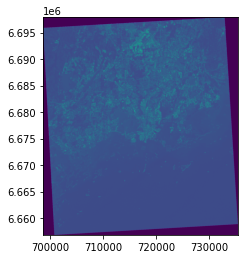

<AxesSubplot:>

In [13]:
import rasterio
from rasterio.plot import show
import numpy as np
import os
%matplotlib inline

# Data dir
data_dir = "L5_data"

# Filepath
fp = os.path.join(data_dir, "Helsinki_masked_p188r018_7t20020529_z34__LV-FIN.tif")

# Open the file:
raster = rasterio.open(fp)

# Plot band 1
show((raster, 1))

如图，是展示band1的像素值的图。下面是不同bands的图

Text(0.5, 1.0, 'Blue')

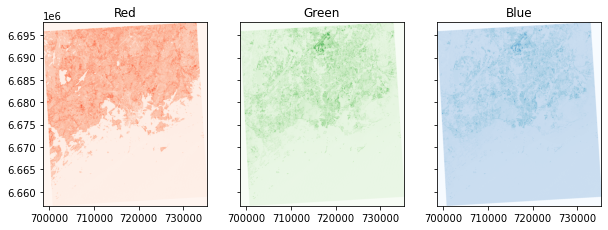

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

# Initialize subplots
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(10, 4), sharey=True)

# Plot Red, Green and Blue (rgb)
show((raster, 4), cmap='Reds', ax=ax1)
show((raster, 3), cmap='Greens', ax=ax2)
show((raster, 1), cmap='Blues', ax=ax3)

# Add titles
ax1.set_title("Red")
ax2.set_title("Green")
ax3.set_title("Blue")

现在把这些图绘制成 RGB 图像。首先，读取这些bands到numpy 数组，然后normalize cell 的值 到 0 至 1 的范围。

In [15]:
# Read the grid values into numpy arrays
red = raster.read(3)
green = raster.read(2)
blue = raster.read(1)

# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

print("Normalized bands")
print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())

Normalized bands
0.0 - 1.0 mean: 0.1423301480606746
0.0 - 1.0 mean: 0.16915069862129217
0.0 - 1.0 mean: 0.23384832284425988


接下来，把不同值stack到一起来产生 RGB 颜色的图，可以使用numpy的dstack() 函数

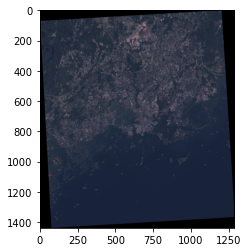

In [16]:
# Create RGB natural color composite
rgb = np.dstack((redn, greenn, bluen))

# Let's see how our color composite looks like
plt.imshow(rgb)

现在看起来就有那味儿了。

使用不同的band configurations，很容易创建的false color composites。一个典型的应用是 用近红外替换蓝色，这样可以用来检测vegetation（显示的红色点）

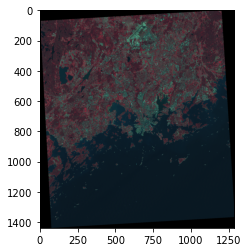

In [17]:
# Read the grid values into numpy arrays
nir = raster.read(4)
red = raster.read(3)
green = raster.read(2)

# Normalize the values using the function that we defined earlier
nirn = normalize(nir)
redn = normalize(red)
greenn = normalize(green)

# Create the composite by stacking
nrg = np.dstack((nirn, redn, greenn))

# Let's see how our color composite looks like
plt.imshow(nrg)

产看不同band的histogram可以使用：

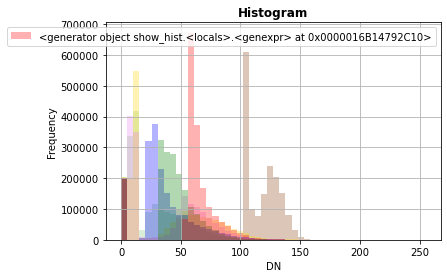

In [18]:
from rasterio.plot import show_hist

show_hist(raster, bins=50, lw=0.0, stacked=False, alpha=0.3,
      histtype='stepfilled', title="Histogram")

这样就很容易看到各个bands的波长的分布了。

## Masking / clipping raster

在栅格数据处理中一个常见任务就是基于一个Polygon来 clip 栅格文件。下面是一个基于一个bounding box来clip一个大raster的例子。

首先，是读取文件，部分展示下

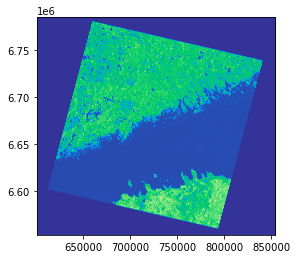

<AxesSubplot:>

In [19]:
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import os
%matplotlib inline

# Data dir
data_dir = "L5_data"

# Input raster
fp = os.path.join(data_dir, "p188r018_7t20020529_z34__LV-FIN.tif")

# Output raster
out_tif = os.path.join(data_dir, "Helsinki_Masked.tif")

# Read the data
data = rasterio.open(fp)

# Visualize the NIR band
show((data, 4), cmap='terrain')

接着创建一个 bounding box，来划定感兴趣的区域

In [20]:
# WGS84 coordinates
minx, miny = 24.60, 60.00
maxx, maxy = 25.22, 60.35
bbox = box(minx, miny, maxx, maxy)

然后根据这个bouding box创建一个GeoDataFrame

In [21]:
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
print(geo)

                                            geometry
0  POLYGON ((25.22000 60.00000, 25.22000 60.35000...


C:\Users\11445\miniconda3\envs\hydroGIS\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


在执行clip之前，首先得确保坐标系是相同的

In [22]:
# Project the Polygon into same CRS as the grid
geo = geo.to_crs(crs=data.crs.data)

# Print crs
geo.crs

C:\Users\11445\miniconda3\envs\hydroGIS\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<Projected CRS: EPSG:32634>
Name: WGS 84 / UTM zone 34N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 18°E and 24°E, northern hemisphere between equator and 84°N, onshore and offshore. Albania. Belarus. Bosnia and Herzegovina. Bulgaria. Central African Republic. Chad. Croatia. Democratic Republic of the Congo (Zaire). Estonia. Finland. Greece. Hungary. Italy. Kosovo. Latvia. Libya. Lithuania. Montenegro. North Macedonia. Norway, including Svalbard and Bjornoys. Poland. Romania. Russian Federation. Serbia. Slovakia. Sudan. Sweden. Ukraine.
- bounds: (18.0, 0.0, 24.0, 84.0)
Coordinate Operation:
- name: UTM zone 34N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

然后再取出geodataframe中的geometry的坐标，使用下面的函数很容易得到

In [23]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [24]:
coords = getFeatures(geo)
print(coords)

[{'type': 'Polygon', 'coordinates': [[[735275.3533476054, 6658919.843253607], [732783.5561207401, 6697846.086795722], [698608.1329965618, 6695816.080575279], [700733.5832412266, 6656875.248540204], [735275.3533476054, 6658919.843253607]]]}]


可以看到多边形的geojson格式的坐标文件，现在开始使用这个polygon来做clip，使用rasterio的mask函数容易实现这一点

In [25]:
# Clip the raster with Polygon
out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)

然后我们需要修改metadata，首先从原始的data文件中copy 过来metadata。

In [26]:
# Copy the metadata
out_meta = data.meta.copy()
print(out_meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 8877, 'height': 8106, 'count': 7, 'crs': CRS.from_epsg(32634), 'transform': Affine(28.5, 0.0, 600466.5,
       0.0, -28.5, 6784966.5)}


接着需要从CRS解析EPSG值，这样才能使用PyCRS库创建一个Proj4 字符串来保证投影信息被正确存储了。

In [27]:
# Parse EPSG code
epsg_code = int(data.crs.data['init'][5:])
print(epsg_code)

32634


现在更新metadata：dimensions，transform（affine），CRS（Proj4 text）

In [28]:
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()}
                         )

最后保存clipped raster

In [29]:
with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(out_img)

现在来检查下结果是否正确

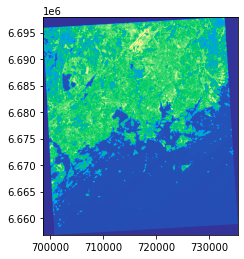

<AxesSubplot:>

In [30]:
# Open the clipped raster file
clipped = rasterio.open(out_tif)

# Visualize
show((clipped, 5), cmap='terrain')

## Raster map algebra

在bands或raster之间执行一些计算是另一个常见的GIS任务。这里以基于Landsat的NDVI（Normalized difference vegetation index）计算为例。如果范围等一致，使用rasterio来执行计算是很直接的，因为rasters的值都是numpy存储的。

NDVI的计算基于两个波段：band-4 的red channel和 band-5 的 Near Infrared（NIR）。

首先，读取数据

36.29418775547201
35.0946303937776
<class 'numpy.ndarray'>


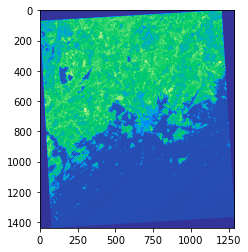

<AxesSubplot:>

In [31]:
import rasterio
import numpy as np
from rasterio.plot import show
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Data dir
data_dir = "data"

# Filepath
fp = os.path.join(data_dir, "Helsinki_masked_p188r018_7t20020529_z34__LV-FIN.tif")

# Open the raster file in read mode
raster = rasterio.open(fp)

# Read red channel (channel number 3)
red = raster.read(3)
# Read NIR channel (channel number 4)
nir = raster.read(4)

# Calculate some stats to check the data
print(red.mean())
print(nir.mean())
print(type(nir))

# Visualize
show(nir, cmap='terrain')

首先，将数据类型从uint8转为float以方便计算

In [32]:
# Convert to floats
red = red.astype('f4')
nir = nir.astype('f4')
nir

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

接下来还要忽略下分母为0的情况

In [33]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

现在就可以计算NDVI了

In [34]:
# Calculate NDVI using numpy arrays
ndvi = (nir - red) / (nir + red)

然后来绘制结果

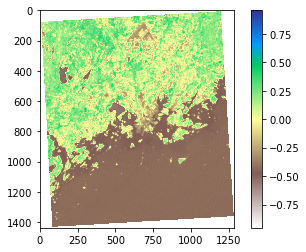

In [35]:
%matplotlib inline
# Plot the NDVI
plt.imshow(ndvi, cmap='terrain_r')
# Add colorbar to show the index
plt.colorbar()

较低的NDVI值在water和urban区域，而绿色的部分有很多vegetation。

## Creating a raster mosaic

一个很常见的应用是merge多个raster files，创建一个raster mosaic。这在rasterio中可以使用merge函数。接下来，会将一个DEM 覆盖到Helsinki Metropolitan 上。有多个DEM文件，使用glob()函数把他们遍历出来。

In [36]:
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import glob
import os
%matplotlib inline

# File and folder paths
dirpath = "L5_data"
out_fp = os.path.join(dirpath, "Helsinki_DEM2x2m_Mosaic.tif")

# Make a search criteria to select the DEM files
search_criteria = "L*.tif"
q = os.path.join(dirpath, search_criteria)
print(q)

L5_data\L*.tif


In [37]:
# glob function can be used to list files from a directory with specific criteria
dem_fps = glob.glob(q)

# Files that were found:
dem_fps

['L5_data\\L4133A.tif',
 'L5_data\\L4133B.tif',
 'L5_data\\L4133C.tif',
 'L5_data\\L4133D.tif',
 'L5_data\\L4133E.tif',
 'L5_data\\L4133F.tif',
 'L5_data\\L4134A.tif',
 'L5_data\\L4134B.tif',
 'L5_data\\L4134C.tif',
 'L5_data\\L4134D.tif',
 'L5_data\\L4134E.tif',
 'L5_data\\L4134F.tif']

In [38]:
# List for the source files
src_files_to_mosaic = []

# Iterate over raster files and add them to source -list in 'read mode'
for fp in dem_fps:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)

src_files_to_mosaic

[<open DatasetReader name='L5_data\L4133A.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4133B.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4133C.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4133D.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4133E.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4133F.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4134A.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4134B.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4134C.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4134D.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4134E.tif' mode='r'>,
 <open DatasetReader name='L5_data\L4134F.tif' mode='r'>]

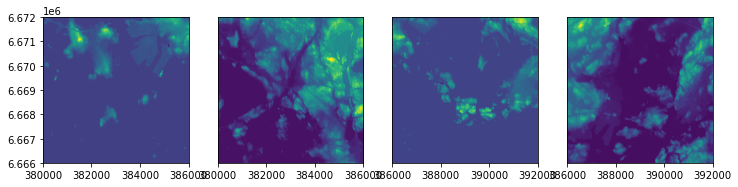

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

# Create 4 plots next to each other
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, nrows=1, figsize=(12, 4))

# Plot first four files
show(src_files_to_mosaic[0], ax=ax1)
show(src_files_to_mosaic[1], ax=ax2)
show(src_files_to_mosaic[2], ax=ax3)
show(src_files_to_mosaic[3], ax=ax4)

# Do not show y-ticks values in last three axis
for ax in [ax2, ax3, ax4]:
    ax.yaxis.set_visible(False)

现在是想把这些文件放到一起

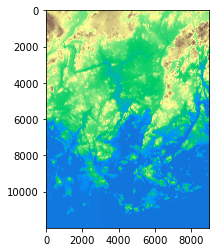

<AxesSubplot:>

In [40]:
# Merge function returns a single mosaic array and the transformation info
mosaic, out_trans = merge(src_files_to_mosaic)

# Plot the result
show(mosaic, cmap='terrain')

保存文件

In [41]:
# Copy the metadata
out_meta = src.meta.copy()

# Update the metadata
out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans,
                 "crs": "+proj=utm +zone=35 +ellps=GRS80 +units=m +no_defs "
                 }
                )

# Write the mosaic raster to disk
with rasterio.open(out_fp, "w", **out_meta) as dest:
    dest.write(mosaic)

## Zonal statistics

依据vector geometries来对raster datasets做统计也是一个很常见的操作，比如计算一个特定区域的平均高程。

Rasterstats 是一个很好用的Python module。

In [43]:
import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats
import osmnx as ox
import geopandas as gpd
import os
import matplotlib.pyplot as plt
%matplotlib inline

# File path
data_dir = "L5_data"
dem_fp = os.path.join(data_dir, "Helsinki_DEM2x2m_Mosaic.tif")

# Read the Digital Elevation Model for Helsinki
dem = rasterio.open(dem_fp)
dem

<open DatasetReader name='L5_data\Helsinki_DEM2x2m_Mosaic.tif' mode='r'>

现在高程数据在读模式。接下来计算两个临近Helsinki的地区的高程：Kallio and Pihlajamäki，然后找出哪一个地方更高。首先，使用一个OSMnx的包来从OpenStreetMap获取这些地区的数据。

可以使用 [Nominatim](https://nominatim.openstreetmap.org/) 来找到上面说的地方对应的关键字，用以用osmnx获取数据。

In [45]:
# Keywords for Kallio and Helsinki in such format that they can be found from OSM
kallio_q = "Kallio, Helsinki, Finland"
pihlajamaki_q = "Pihlajamäki, Malmi, Helsinki, Finland"

# Retrieve the geometries of those areas using osmnx
kallio = ox.geocode_to_gdf(kallio_q)
pihlajamaki = ox.geocode_to_gdf(pihlajamaki_q)

# Reproject to same coordinate system as the
kallio = kallio.to_crs(crs=dem.crs)
pihlajamaki = pihlajamaki.to_crs(crs=dem.crs)

type(kallio)

geopandas.geodataframe.GeoDataFrame

现在已经从OSMnx获取了数据，并存储进了GeoDataFrames。现在绘图看看数据集：

<AxesSubplot:>

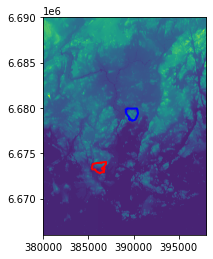

In [46]:
# Plot the Polygons on top of the DEM
ax = kallio.plot(facecolor='None', edgecolor='red', linewidth=2)
ax = pihlajamaki.plot(ax=ax, facecolor='None', edgecolor='blue', linewidth=2)

# Plot DEM
show((dem, 1), ax=ax)

Kallio or Pihlajamäki，哪一个地方的海拔更高呢？使用 zonal statistics 来解决。

首先，读取DEM数据到nunmpy数组，并获取raster的affine的值

In [47]:
# Read the raster values
array = dem.read(1)

# Get the affine
affine = dem.transform

现在就可以使用 函数计算 zonal statistics了。

In [48]:
# Calculate zonal statistics for Kallio
zs_kallio = zonal_stats(kallio, array, affine=affine, stats=['min', 'max', 'mean', 'median', 'majority'])

# Calculate zonal statistics for Pihlajamäki
zs_pihla = zonal_stats(pihlajamaki, array, affine=affine, stats=['min', 'max', 'mean', 'median', 'majority'])

print(zs_kallio)
print(zs_pihla)

C:\Users\11445\miniconda3\envs\hydroGIS\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


[{'min': -2.1760001182556152, 'max': 37.388999938964844, 'mean': 12.723461755223713, 'median': 11.145000457763672, 'majority': 0.3490000069141388}]
[{'min': 8.621999740600586, 'max': 46.30400085449219, 'mean': 24.559831516315707, 'median': 24.177000045776367, 'majority': 10.41100025177002}]


容易看到Pihlajamäki略高一点。

## Read Cloud Optimized Geotiffs

最后是从云端读取数据的一些操作。更多内容参考：https://geohackweek.github.io/raster/04-workingwithrasters/

In [49]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Specify the path for Landsat TIF on AWS
fp = 'http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF'

# See the profile
with rasterio.open(fp) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7821, 'height': 7951, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, 0.0, 204285.0,
       0.0, -30.0, 4268115.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


绘制一个低分辨率的图

Decimation factor= 81
array type:  <class 'numpy.ndarray'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Text(0, 0.5, 'Row #')

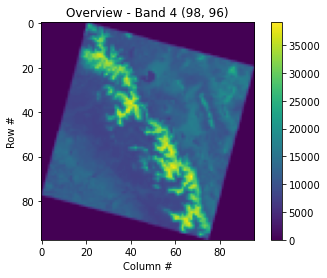

In [50]:
%matplotlib inline
# Open the COG
with rasterio.open(fp) as src:
    # List of overviews from biggest to smallest
    oviews = src.overviews(1)

    # Retrieve the smallest thumbnail
    oview = oviews[-1]
    print('Decimation factor= {}'.format(oview))
    # NOTE this is using a 'decimated read' (http://rasterio.readthedocs.io/en/latest/topics/resampling.html)
    thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

print('array type: ',type(thumbnail))
print(thumbnail)

plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

高分辨率的图

Text(0, 0.5, 'Row #')

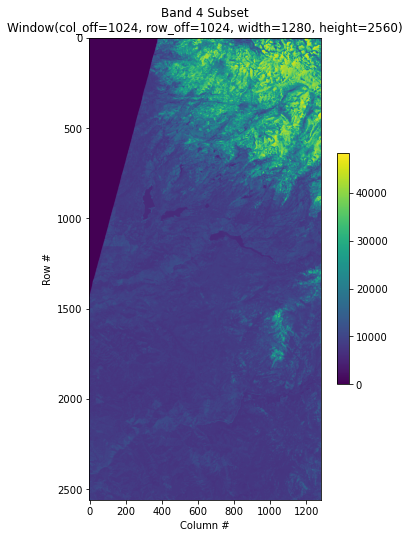

In [51]:
#https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html
#rasterio.windows.Window(col_off, row_off, width, height)
window = rasterio.windows.Window(1024, 1024, 1280, 2560)

with rasterio.open(fp) as src:
    subset = src.read(1, window=window)

plt.figure(figsize=(6,8.5))
plt.imshow(subset)
plt.colorbar(shrink=0.5)
plt.title(f'Band 4 Subset\n{window}')
plt.xlabel('Column #')
plt.ylabel('Row #')